In [1]:
import sys,os
sys.path.append(os.pardir)
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn import linear_model
from cmf.crmf import CRMF
from cmf.cnimf import CNIMF
%matplotlib inline

In [66]:
dir_path = 'D:/UCI/gas'
file_name = 'ethylene_methane.txt'
file_path = dir_path + '/' + file_name

In [67]:
data = pd.read_csv(file_path, delim_whitespace=True)

In [68]:
gas_columns = list(data.columns[1:3])
used_columns = list(data.columns[3:19])
observable_columns = list(data.columns[5:7])
hidden_columns = list(set(used_columns) - set(observable_columns))
gas_column_idxs = [1,2]
observable_column_idxs = [used_columns.index(column_name) for column_name in observable_columns]
hidden_column_idxs = [used_columns.index(column_name) for column_name in hidden_columns]

In [69]:
interval = 200
raw_down_sampled = data[::interval]
m = raw_down_sampled[used_columns].mean(axis = 0)
s = raw_down_sampled[used_columns].std(axis = 0)
down_sampled = pd.DataFrame(raw_down_sampled)
down_sampled[used_columns] = raw_down_sampled[used_columns].sub(m).div(s)

In [43]:
train_data_length = 250000
test_data_length = 250000
train_start_list = [1750000, 2250000, 2750000, 3250000, 250000, 750000, 1250000]
test_start_list = [250000, 750000, 1250000, 1750000, 2250000, 2750000, 3250000]
regression_window_length_list = [400, 600, 800, 1000, 1200]
l1_weight_list = [0.01, 0.02, 0.03, 0.04, 0.05]
lr_error_table = np.float('nan') * np.ones(len(train_start_list)) 
lrn_error_table = np.float('nan') * np.ones(len(train_start_list)) 
mlr_error_table = np.float('nan') * np.ones([len(regression_window_length_list), len(train_start_list)]) 
mlrn_error_table = np.float('nan') * np.ones([len(regression_window_length_list), len(train_start_list)]) 
crmf_completion_error_table = np.float('nan') * np.ones((len(l1_weight_list), len(train_start_list))) 
cnimf_completion_error_table = np.float('nan') * np.ones((len(train_start_list),))
cnimf_with_bias_modification_completion_error_table = np.float('nan') * np.ones((len(train_start_list),)) 
test_data_mean_square_table = np.float('nan') * np.ones((len(train_start_list),)) 


# Hyperparameter Selection

In [44]:
for i_start in range(len(train_start_list)):
    train_start = train_start_list[i_start] // interval
    test_start = test_start_list[i_start] // interval
    train_end = train_start + (train_data_length // interval) 
    test_end = test_start + (test_data_length // interval)
    X_train = np.array(down_sampled[observable_columns][train_start:train_end].diff())[1:]
    Y_train = np.array(down_sampled[hidden_columns][train_start:train_end].diff())[1:]
    XY_train = np.array(down_sampled[used_columns][train_start:train_end].diff())[1:]
    F_train = np.ones(XY_train.shape)
    X_test = np.array(down_sampled[observable_columns][test_start:test_end].diff())[1:]
    Y_test = np.array(down_sampled[hidden_columns][test_start:test_end].diff())[1:]
    XY_test = np.array(down_sampled[used_columns][test_start:test_end].diff())[1:]
    F_test = np.zeros(XY_test.shape)
    F_test[:, observable_column_idxs] = 1
    XO_test = XY_test * F_test
    lr = linear_model.LinearRegression()
    lr.fit(X_train, Y_train)
    Y_lr = lr.predict(X_test) 
    lr_error = np.mean((Y_lr - Y_test) ** 2)
    lr_error_table[i_start] = lr_error
    lrn = linear_model.LinearRegression(normalize=True)
    lrn.fit(X_train, Y_train)
    Y_lrn = lrn.predict(X_test) 
    lrn_error = np.mean((Y_lrn - Y_test) ** 2)
    lrn_error_table[i_start] = lrn_error
    for i_regression_window_length in range(len(regression_window_length_list)):
        regression_window_length = regression_window_length_list[i_regression_window_length]
        n_window_samples = regression_window_length // interval
        XX_train = np.concatenate([np.roll(np.array(down_sampled[observable_columns].diff()), i, axis=0) for i in range(-n_window_samples, n_window_samples)], axis = 1)[train_start:train_end, :][1:,:]
        XX_test = np.concatenate([np.roll(np.array(down_sampled[observable_columns].diff()), i, axis=0) for i in range(-n_window_samples, n_window_samples)], axis = 1)[test_start:test_end, :][1:,:]
        mlr = linear_model.LinearRegression()
        mlr.fit(XX_train, Y_train)
        Y_mlr = mlr.predict(XX_test) 
        mlr_error = np.mean((Y_mlr - Y_test) ** 2)
        mlr_error_table[i_regression_window_length, i_start] = mlr_error
        mlrn = linear_model.LinearRegression(normalize=True)
        mlrn.fit(XX_train, Y_train)
        Y_mlrn = mlrn.predict(XX_test) 
        mlrn_error = np.mean((Y_mlrn - Y_test) ** 2)
        mlrn_error_table[i_regression_window_length, i_start] = mlrn_error
    for i_l1_weight in range(len(l1_weight_list)):
        l1_weight = l1_weight_list[i_l1_weight]
        crmf_arg_dict = dict(
            convolution_max = 200,
            true_width = 10000 // interval,
            true_n_components = 2,
            activation_l1_weight = l1_weight,
            activation_l2_weight = 0.0,
            base_max = 10.0,
            convergence_threshold = 0.0000001,
            loop_max = 100,
            fit_accelerator_max = 0.0,
            transfer_accelerator_max = 0.0,
            verbose = 0,
            initialization = 'smooth_svd')
        crmf = CRMF(**crmf_arg_dict)
        loss_weight = 1.0 / np.ones(XY_train.shape[1])
        base_l2_weight = 1.0 / np.ones(XY_train.shape[1])
        base_l1_weight = 0.0 / np.ones(XY_train.shape[1])
        crmf.fit(XY_train, None, filtre = F_train, loss_weight = loss_weight, base_l1_weight = base_l1_weight, base_l2_weight = base_l2_weight)
        crmf.transfer(XO_test, transfer_filtre = F_test)
        XY_crmf = crmf.transfer_approximated
        crmf_completion_error = np.mean(((XY_crmf - XY_test)[:, hidden_column_idxs]) ** 2)
        crmf_completion_error_table[i_l1_weight, i_start] = crmf_completion_error
        

In [45]:
print(np.mean(lr_error_table))
print(np.mean(mlr_error_table, axis = 1))
print(np.mean(crmf_completion_error_table, axis = 1))
crmf_completion_error_table


0.0679615794641
[ 0.06790717  0.06802637  0.06797975  0.06804286  0.06825187]
[ 0.0678708   0.06788508  0.06792222  0.06788659  0.06791917]


array([[ 0.00185666,  0.20429177,  0.00222425,  0.26037123,  0.00217147,
         0.00235795,  0.00182231],
       [ 0.00186511,  0.20430377,  0.00219936,  0.26035376,  0.00214783,
         0.00250028,  0.00182543],
       [ 0.00185754,  0.20431893,  0.00218627,  0.26035702,  0.00213292,
         0.00277797,  0.00182488],
       [ 0.00186122,  0.20433001,  0.00212628,  0.26036464,  0.0021469 ,
         0.00254351,  0.00183359],
       [ 0.00187655,  0.20437475,  0.00214725,  0.26036076,  0.00220138,
         0.00267153,  0.00180201]])

# Evaluation

In [25]:
train_data_length = 250000
test_data_length = 250000
train_start_list = [1750000, 2250000, 2750000, 3250000, 250000, 750000, 1250000]
test_start_list = [500000, 1000000, 1500000, 2000000, 2500000, 3000000, 3500000]
# train_start_list = [750000]
# test_start_list = [2750000]
regression_window_length_list = [400]
l1_weight_list = [0.02]
lr_error_table = np.float('nan') * np.ones(len(train_start_list)) 
lrn_error_table = np.float('nan') * np.ones(len(train_start_list)) 
mlr_error_table = np.float('nan') * np.ones([len(regression_window_length_list), len(train_start_list)]) 
mlrn_error_table = np.float('nan') * np.ones([len(regression_window_length_list), len(train_start_list)]) 
crmf_completion_error_table = np.float('nan') * np.ones((len(l1_weight_list), len(train_start_list))) 
cnimf_completion_error_table = np.float('nan') * np.ones((len(train_start_list),))
cnimf_with_bias_modification_completion_error_table = np.float('nan') * np.ones((len(train_start_list),)) 
test_data_mean_square_table = np.float('nan') * np.ones((len(train_start_list),)) 


In [35]:
for i_start in range(len(train_start_list)):
    train_start = train_start_list[i_start] // interval
    test_start = test_start_list[i_start] // interval
    train_end = train_start + (train_data_length // interval) 
    test_end = test_start + (test_data_length // interval)
    X_train = np.array(down_sampled[observable_columns][train_start:train_end].diff())[1:]
    Y_train = np.array(down_sampled[hidden_columns][train_start:train_end].diff())[1:]
    XY_train = np.array(down_sampled[used_columns][train_start:train_end].diff())[1:]
    F_train = np.ones(XY_train.shape)
    X_test = np.array(down_sampled[observable_columns][test_start:test_end].diff())[1:]
    Y_test = np.array(down_sampled[hidden_columns][test_start:test_end].diff())[1:]
    XY_test = np.array(down_sampled[used_columns][test_start:test_end].diff())[1:]
    F_test = np.zeros(XY_test.shape)
    F_test[:, observable_column_idxs] = 1
    XO_test = XY_test * F_test
    lr = linear_model.LinearRegression()
    lr.fit(X_train, Y_train)
    Y_lr = lr.predict(X_test) 
    lr_error = np.mean((Y_lr - Y_test) ** 2)
    lr_error_table[i_start] = lr_error
    lrn = linear_model.LinearRegression(normalize=True)
    lrn.fit(X_train, Y_train)
    Y_lrn = lrn.predict(X_test) 
    lrn_error = np.mean((Y_lrn - Y_test) ** 2)
    lrn_error_table[i_start] = lrn_error
    for i_regression_window_length in range(len(regression_window_length_list)):
        regression_window_length = regression_window_length_list[i_regression_window_length]
        n_window_samples = regression_window_length // interval
        XX_train = np.concatenate([np.roll(np.array(down_sampled[observable_columns].diff()), i, axis=0) for i in range(-n_window_samples, n_window_samples)], axis = 1)[train_start:train_end, :][1:,:]
        XX_test = np.concatenate([np.roll(np.array(down_sampled[observable_columns].diff()), i, axis=0) for i in range(-n_window_samples, n_window_samples)], axis = 1)[test_start:test_end, :][1:,:]
        mlr = linear_model.LinearRegression()
        mlr.fit(XX_train, Y_train)
        Y_mlr = mlr.predict(XX_test) 
        mlr_error = np.mean((Y_mlr - Y_test) ** 2)
        mlr_error_table[i_regression_window_length, i_start] = mlr_error
        mlrn = linear_model.LinearRegression(normalize=True)
        mlrn.fit(XX_train, Y_train)
        Y_mlrn = mlrn.predict(XX_test) 
        mlrn_error = np.mean((Y_mlrn - Y_test) ** 2)
        mlrn_error_table[i_regression_window_length, i_start] = mlrn_error
    for i_l1_weight in range(len(l1_weight_list)):
        l1_weight = l1_weight_list[i_l1_weight]
        crmf_arg_dict = dict(
            convolution_max = 200,
            true_width = 10000 // interval,
            true_n_components = 2,
            activation_l1_weight = l1_weight,
            activation_l2_weight = 0.0,
            base_max = 10.0,
            convergence_threshold = 0.0000001,
            loop_max = 100,
            fit_accelerator_max = 0.0,
            transfer_accelerator_max = 0.0,
            verbose = 0,
            initialization = 'smooth_svd')
        crmf = CRMF(**crmf_arg_dict)
        loss_weight = 1.0 / np.ones(XY_train.shape[1])
        base_l2_weight = 1.0 / np.ones(XY_train.shape[1])
        base_l1_weight = 0.0 / np.ones(XY_train.shape[1])
        crmf.fit(XY_train, None, filtre = F_train, loss_weight = loss_weight, base_l1_weight = base_l1_weight, base_l2_weight = base_l2_weight)
        crmf.transfer(XO_test, transfer_filtre = F_test)
        XY_crmf = crmf.transfer_approximated
        crmf_completion_error = np.mean(((XY_crmf - XY_test)[:, hidden_column_idxs]) ** 2)
        crmf_completion_error_table[i_l1_weight, i_start] = crmf_completion_error
    cnimf_arg_dict = dict(
        convolution_max = 200,
        true_width = 10000 // interval,
        true_n_components = 2,
        base_max = 10.0,
        convergence_threshold = 0.0000001,
        loop_max = 100)
    cnimf = CNIMF(**cnimf_arg_dict)
    min_XY = np.min(XY_train)
    XY_train_shifted = XY_train - min_XY
    cnimf.fit(XY_train_shifted, None, filtre = F_train)
    XO_test_shifted = np.maximum(XO_test - min_XY, np.zeros(XO_test.shape))
    cnimf.transfer(XO_test_shifted, transfer_filtre = F_test)
    XY_cnimf = cnimf.transfer_approximated + min_XY
    cnimf_completion_error = np.mean(((XY_cnimf - XY_test)[:, hidden_column_idxs]) ** 2)
    cnimf_bias = (XY_cnimf - XY_test).mean()
    cnimf_with_bias_modification_completion_error = np.mean(((XY_cnimf - cnimf_bias - XY_test)[:, hidden_column_idxs]) ** 2)
    cnimf_completion_error_table[i_start] = cnimf_completion_error
    cnimf_with_bias_modification_completion_error_table[i_start] = cnimf_with_bias_modification_completion_error
    test_data_mean_square_table[i_start] = np.mean(XY_test ** 2)
        

In [36]:
print(np.mean(lr_error_table))
print(np.mean(mlr_error_table, axis = 1))
print(np.mean(crmf_completion_error_table, axis = 1))
print(np.mean(cnimf_completion_error_table, axis = 0))
print(np.mean(cnimf_with_bias_modification_completion_error_table, axis = 0))
print(np.mean(test_data_mean_square_table, axis = 0))
crmf_completion_error_table


0.00220558522022
[ 0.00215763  0.00231566  0.00263295  0.00308433  0.0033637 ]
[ 0.00213703]
14.6495658103
12.5722720679
0.00305991026986


array([[ 0.00176531,  0.00244339,  0.00240543,  0.00223992,  0.00208533,
         0.0020425 ,  0.00197736]])

-0.000476300078367
-0.267321130716


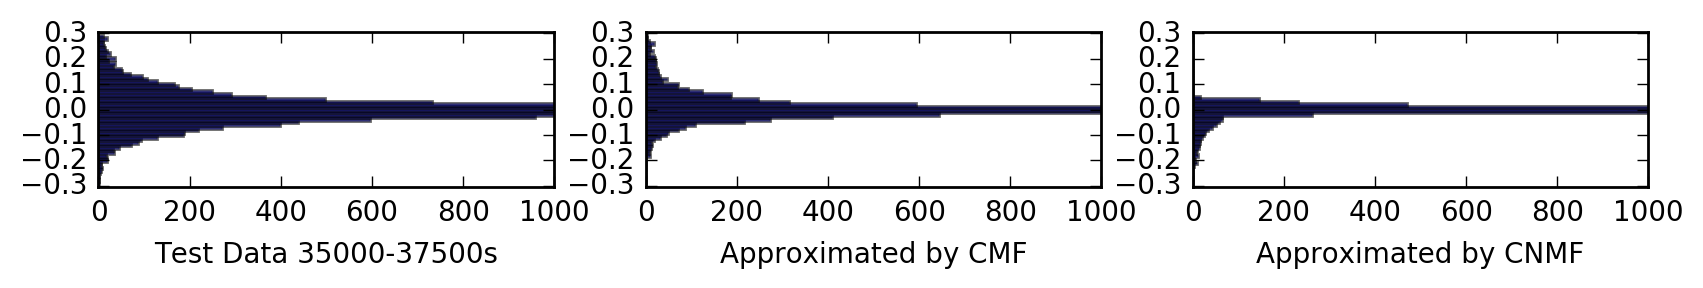

In [54]:
%config InlineBackend.figure_format = 'retina'
minimum_center = -0.3
maximum_center = 0.3
interval = 0.01
x_lim_max = 1000
edges = np.arange(minimum_center-interval/2, maximum_center+interval/2, interval, dtype=np.float32)
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(10,1))
data_list = [XY_test, XY_crmf, XY_cnimf]
x_labels = ['Test Data 35000-37500s', 'Approximated by CMF', 'Approximated by CNMF']
for (ax, data_elements, x_label) in zip(axs, data_list, x_labels):
    ax.hist(np.array(data_elements).reshape((-1, 1)), bins=edges, alpha=0.6, orientation='horizontal')
    ax.set_ylim(minimum_center-interval/2, maximum_center+interval/2)
    ax.set_xlim(0, x_lim_max)
    ax.set_xlabel(x_label)
# print('result')
# plt.hist(XY_crmf.reshape((-1,1)), bins=edges, alpha=0.6)
# plt.hist((XY_cnimf - cnimf_bias).reshape((-1,1)), bins=edges, alpha=0.6)
print(cnimf_bias)
print(min_XY)
fig.savefig('../dat/estimation/histogram.png', format='png')
fig.savefig('../dat/estimation/histogram.pdf', format='pdf')

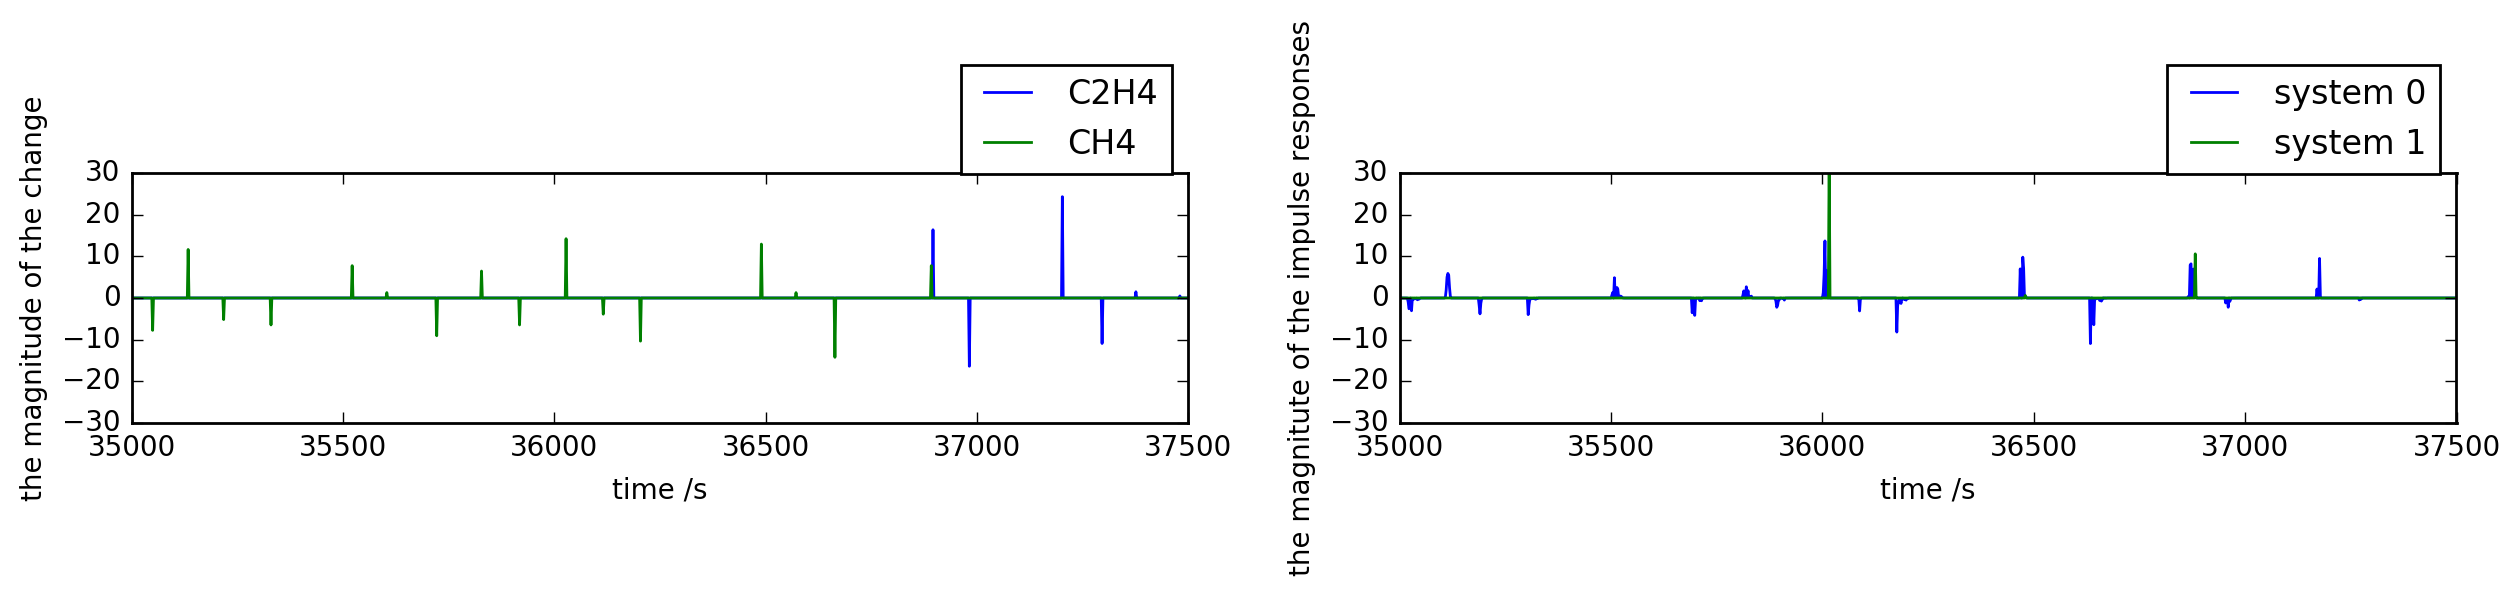

In [62]:
%config InlineBackend.figure_format = 'retina'
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15, 2))
Truth_test = np.array(down_sampled[data.columns[1:3]][test_start:test_end].diff())[1:]
axs[0].plot(np.arange(35002,37500,2), (Truth_test / np.std(Truth_test, axis = 0))[:, 0], label='C2H4')
axs[0].plot(np.arange(35002,37500,2), (Truth_test / np.std(Truth_test, axis = 0))[:, 1], label='CH4')
axs[0].set_xlabel('time /s')
axs[0].set_ylabel('the magnitude of the change')
axs[0].set_ylim(-30, 30)
axs[0].legend(bbox_to_anchor=(1, 1.5), loc='upper right')
Z = crmf.transfer_activation
axs[1].plot(np.arange(35002,37500,2),(-Z/np.std(Z, axis=0))[:,0], label='system 0')
axs[1].plot(np.arange(35002,37500,2),(-Z/np.std(Z, axis=0))[:,1], label='system 1')
axs[1].set_xlabel('time /s')
axs[1].set_ylabel('the magnitute of the impulse responses')
axs[1].set_ylim(-30, 30)
axs[1].legend(bbox_to_anchor=(1, 1.5), loc='upper right')
# fig.tight_layout()
fig.subplots_adjust(top=0.75)
fig.savefig('../dat/estimation/density_signal.png', format='png')
fig.savefig('../dat/estimation/density_signal.pdf', format='pdf')

# Random Missing Situation

In [112]:
train_data_length = 250000
test_data_length = 250000
train_start_list = [1750000, 2250000, 2750000, 3250000, 250000, 750000, 1250000]
test_start_list = [500000, 1000000, 1500000, 2000000, 2500000, 3000000, 3500000]
l1_weight_list = [0.02]
existence_probability_list = [0.125]
crmf_completion_error_table = np.float('nan') * np.ones((len(l1_weight_list), len(existence_probability_list), len(train_start_list))) 
cnimf_completion_error_table = np.float('nan') * np.ones((len(existence_probability_list), len(train_start_list),))
cnimf_with_bias_modification_completion_error_table = np.float('nan') * np.ones((len(existence_probability_list), len(train_start_list),)) 
test_data_mean_square_table = np.float('nan') * np.ones((len(train_start_list),)) 


In [113]:
for i_start in range(len(train_start_list)):
    train_start = train_start_list[i_start] // interval
    test_start = test_start_list[i_start] // interval
    train_end = train_start + (train_data_length // interval) 
    test_end = test_start + (test_data_length // interval)
    XY_train = np.array(down_sampled[used_columns][train_start:train_end].diff())[1:]
    F_train = np.ones(XY_train.shape)
    crmfs = []
    for l1_weight in l1_weight_list:
        crmf_arg_dict = dict(
            convolution_max = 200,
            true_width = 10000 // interval,
            true_n_components = 2,
            activation_l1_weight = l1_weight,
            activation_l2_weight = 0.0,
            base_max = 10.0,
            convergence_threshold = 0.0000001,
            loop_max = 100,
            fit_accelerator_max = 0.0,
            transfer_accelerator_max = 0.0,
            verbose = 0,
            initialization = 'smooth_svd')
        crmf = CRMF(**crmf_arg_dict)
        loss_weight = 1.0 / np.ones(XY_train.shape[1])
        base_l2_weight = 1.0 / np.ones(XY_train.shape[1])
        base_l1_weight = 0.0 / np.ones(XY_train.shape[1])
        crmf.fit(XY_train, None, filtre = F_train, loss_weight = loss_weight, base_l1_weight = base_l1_weight, base_l2_weight = base_l2_weight)
        crmfs.append(crmf)
    cnimf_arg_dict = dict(
        convolution_max = 200,
        true_width = 10000 // interval,
        true_n_components = 2,
        base_max = 10.0,
        convergence_threshold = 0.0000001,
        loop_max = 100)
    cnimf = CNIMF(**cnimf_arg_dict)
    min_XY = np.min(XY_train)
    XY_train_shifted = XY_train - min_XY
    cnimf.fit(XY_train_shifted, None, filtre = F_train)
    for (i_existence_probability, existence_probability) in enumerate(existence_probability_list):
        XY_test = np.array(down_sampled[used_columns][test_start:test_end].diff())[1:]
        F_test = np.random.binomial(1, existence_probability, XY_test.shape)
        XO_test = XY_test * F_test
        for (i_l1_weight, crmf) in enumerate(crmfs):
            crmf.transfer(XO_test, transfer_filtre = F_test)
            XY_crmf = crmf.transfer_approximated
            crmf_completion_error = np.mean(((XY_crmf - XY_test)[1-F_test]) ** 2)
            crmf_completion_error_table[i_l1_weight, i_existence_probability, i_start] = crmf_completion_error
        XO_test_shifted = np.maximum(XO_test - min_XY, np.zeros(XO_test.shape))
        cnimf.transfer(XO_test_shifted, transfer_filtre = F_test)
        XY_cnimf = cnimf.transfer_approximated + min_XY
        cnimf_completion_error = np.mean(((XY_cnimf - XY_test)[1-F_test]) ** 2)
        cnimf_bias = (XY_cnimf - XY_test).mean()
        cnimf_with_bias_modification_completion_error = np.mean(((XY_cnimf - cnimf_bias - XY_test)[1-F_test]) ** 2)
        cnimf_completion_error_table[i_existence_probability, i_start] = cnimf_completion_error
        cnimf_with_bias_modification_completion_error_table[i_existence_probability, i_start] = cnimf_with_bias_modification_completion_error
    test_data_mean_square_table[i_start] = np.mean(XY_test ** 2)
        

In [116]:
print(np.mean(crmf_completion_error_table, axis = -1))
print(np.mean(cnimf_completion_error_table, axis = -1))
print(np.mean(cnimf_with_bias_modification_completion_error_table, axis = -1))
print(np.mean(test_data_mean_square_table, axis = -1))
print(test_data_mean_square_table)
print(crmf_completion_error_table)


[[ 0.01042065]]
[ 3.19141629]
[ 5.42881975]
0.00305991026986
[ 0.00192833  0.00362195  0.00376288  0.00333423  0.00325919  0.00269432
  0.00281846]
[[[ 0.00161925  0.00087958  0.0014368   0.03707047  0.02723745  0.00194452
    0.00275646]]]
